nella consegna dice che l'immagine di riferimento è la sinistra ma invece è sempre quella destra

## Parametri dataset

1. disp_min e disp_max
    - Definiscono l’intervallo di disparità in cui l’algoritmo deve cercare la corrispondenza.
    - disp_min = 0; disp_max = 15 -> Significa: $d \in [0, 15]$
    - Riduce il costo computazionale
    - Evita corrispondenze sbagliate

2. disp_scale
    - the scale factor needed to obtain a disparity map coherent with the ground-truth disparity map (specified by the parameter disp_scale)
    - Serve a convertire la disparità stimata nel formato della ground truth.
    - la ground-truth disparity map non è in pixel interi ma in pixel × 16 (disparità sub-pixel);
        - con 16 valore di disp_scale
    - In pratica, se il tuo algoritmo produce: d = 7.5 pixel
    - devi salvarlo come: 7.5 × 16 = 120 nella disparity_map per confrontarlo con la disparity_map_ground_truth
    - Questo permette precisione sub-pixel della disparity senza usare float (che non possono essere mostrati in una scala di grigi)

3. ignore_border
   - the width of the image border to be ignored when evaluating the experimental results
   - Significa non valutare:
        - primi 18 pixel a sinistra/destra
        - primi 18 pixel in alto/basso
    - Ai bordi non tutte le disparità sono valide
        - i pixel potrebbero non avere corrispondenza
        - molti algoritmi usano finestre che “escono” dall’immagine
    - Penalizzare la bontà dell'algoritmo a causa di questi pixel sarebbe ingiusto.

4. ref
    - immagine da usare come riferimento per calcolare la disparity map
    - le corrispondenze andranno cercate nell'altra immagine

5. groundtruth
   - disparity map che fa da ground truth per valutare la bontà della disparity map che produciamo

# First task: development of a baseline stereo matching algorithm

Students are required to develop an **area-based stereo matching algorithm** based on comparing pixel intensities within windows centred at candidate corresponding points. More precisely, for each point in the reference image, the window centered at the point is compared to all those centered at the points in the other image laying on the same row and within the disparity range. 

The comparison between windows must be carried out according to the **SAD (Sum of Absolute Differences) dissimilarity function**. The window providing the lowest SAD determines the corresponding point in the other image and thus the disparity value for the given point in the reference image (**winner-takes-all approach**).

Then, results must be evaluated quantitatively according to the methodology described in Section 4.1. Based on analysis of the obtained results, students should also comment on the main issues that cause errors when computing disparities by the baseline algorithm.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

shapes: l=(380, 434, 3); r=(380, 434, 3)


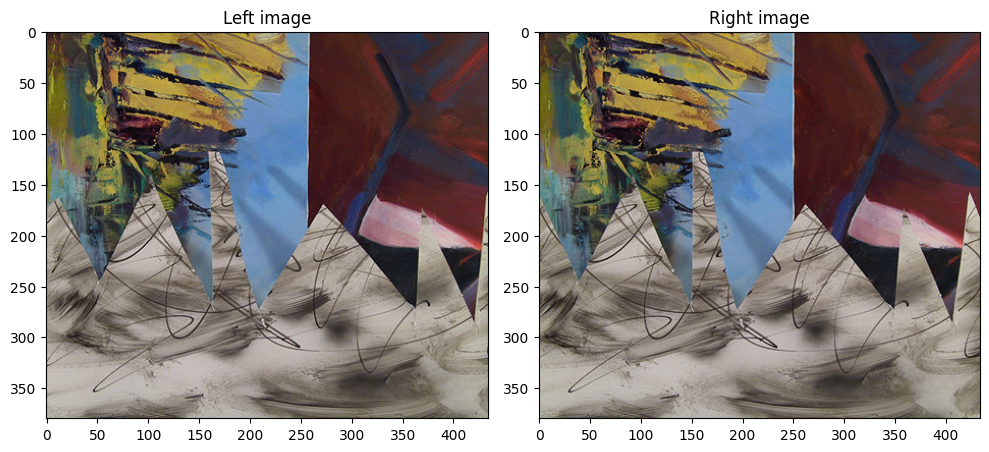

In [9]:
path_im_left = "./StereoDataset/sawtooth/im2.ppm"
path_im_right = "./StereoDataset/sawtooth/im6.ppm"

im_l = cv2.imread(path_im_left)
im_r = cv2.imread(path_im_right)

print(f"shapes: l={im_l.shape}; r={im_r.shape}")

plt.figure(figsize=(10,8))

plt.subplot(1, 2, 1)
plt.title("Left image")
plt.imshow(cv2.cvtColor(im_l, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title("Right image")
plt.imshow(cv2.cvtColor(im_r, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()


In [ ]:
window_size = 7 # TODO: capisci come scegliere questo

